<a href="https://colab.research.google.com/github/liviasydriao/atividade_04/blob/main/Fruit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pré-Processamento

Importações:

In [ ]:
!pip install opendatasets
!pip install pandas
import opendatasets as od
import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import matplotlib.image as mpimg
import random
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array
import pathlib
import numpy as np
import os
import cv2
import hashlib



Será inserido abaixo:


> Adicionar aspas


* **username**":"lviabraga"
* **key**:"95e9c1fd8a41fdc6c5344463d11adba6"



In [2]:
od.download(
	"https://www.kaggle.com/datasets/sshikamaru/fruit-recognition")

Skipping, found downloaded files in "./fruit-recognition" (use force=True to force download)


Acima é feito o download do dataset do kaggle diretamente para esse notebook do google colab

Definindo o caminho do conjunto de dados.
Função os.walk(): para percorrer uma árvore de diretórios começando pelo caminho "../input/fruit-recognition".
O caminho do diretório atual é armazenado na variável dirpath, a lista de nomes de subdiretórios é armazenada na variável dirnames, e a lista de nomes de arquivos é armazenada na variável filenames.

In [ ]:
for dirpath, dirnames, filenames in os.walk("/content/fruit-recognition"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

### Verificando valores nulos e Duplicatas:

In [4]:
def check_for_null_images(directory):
    null_images = []
    for filename in os.listdir(directory):
        # Verifique se o arquivo é uma imagem (você pode ajustar os formatos de imagem conforme necessário)
        if filename.endswith(".jpg") or filename.endswith(".png"):
            filepath = os.path.join(directory, filename)
            # Tente carregar a imagem
            try:
                img = cv2.imread(filepath)
                # Verifique se a imagem é nula (todos os pixels são pretos)
                if img is None or img.sum() == 0:
                    null_images.append(filepath)
            except Exception as e:
                print(f"Erro ao processar {filepath}: {e}")
    return null_images

# Diretório de treinamento
train_dir = "../content/fruit-recognition/train/train/"
null_images_train = check_for_null_images(train_dir)
if null_images_train:
    print("Imagens nulas encontradas no conjunto de treinamento:")
    for img_path in null_images_train:
        print(img_path)
else:
    print("Nenhuma imagem nula encontrada no conjunto de treinamento.")

# Diretório de teste
test_dir = "../content/fruit-recognition/test/test/"
null_images_test = check_for_null_images(test_dir)
if null_images_test:
    print("Imagens nulas encontradas no conjunto de teste:")
    for img_path in null_images_test:
        print(img_path)
else:
    print("Nenhuma imagem nula encontrada no conjunto de teste.")


Nenhuma imagem nula encontrada no conjunto de treinamento.
Nenhuma imagem nula encontrada no conjunto de teste.


In [ ]:
def generate_image_hash(image):
    """
    Função para gerar o hash de uma imagem.
    """
    # Redimensione a imagem para uma resolução fixa para garantir consistência no hash
    resized_image = cv2.resize(image, (8, 8))
    # Converta a imagem para escala de cinza
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    # Calcule a média dos pixels
    mean_value = gray_image.mean()
    # Gere o hash com base na média dos pixels
    hash_value = ""
    for i in range(gray_image.shape[0]):
        for j in range(gray_image.shape[1]):
            if gray_image[i, j] > mean_value:
                hash_value += "1"
            else:
                hash_value += "0"
    return hash_value

def find_duplicate_images(directory):
    """
    Função para encontrar imagens duplicadas em um diretório.
    """
    image_hashes = {}
    duplicate_images = []

    for filename in os.listdir(directory):
        # Verifique se o arquivo é uma imagem (você pode ajustar os formatos de imagem conforme necessário)
        if filename.endswith(".jpg") or filename.endswith(".png"):
            filepath = os.path.join(directory, filename)
            # Tente carregar a imagem
            try:
                img = cv2.imread(filepath)
                # Gere o hash da imagem
                img_hash = generate_image_hash(img)
                # Verifique se já encontramos um hash idêntico
                if img_hash in image_hashes:
                    duplicate_images.append((filepath, image_hashes[img_hash]))
                else:
                    image_hashes[img_hash] = filepath
            except Exception as e:
                print(f"Erro ao processar {filepath}: {e}")

    return duplicate_images

# Diretório de treinamento
train_dir = "../content/fruit-recognition/train/train/"
duplicate_images_train = find_duplicate_images(train_dir)
if duplicate_images_train:
    print("Duplicatas encontradas no conjunto de treinamento:")
    for img_path1, img_path2 in duplicate_images_train:
        print(f"Duplicata 1: {img_path1}")
        print(f"Duplicata 2: {img_path2}")
else:
    print("Nenhuma duplicata encontrada no conjunto de treinamento.")

# Diretório de teste
test_dir = "../content/fruit-recognition/test/test/"
duplicate_images_test = find_duplicate_images(test_dir)
if duplicate_images_test:
    print("Duplicatas encontradas no conjunto de teste:")
    for img_path1, img_path2 in duplicate_images_test:
        print(f"Duplicata 1: {img_path1}")
        print(f"Duplicata 2: {img_path2}")
else:
    print("Nenhuma duplicata encontrada no conjunto de teste.")


Configurando o caminho para TREINO E TESTE:

In [ ]:
train_path = "../content/fruit-recognition/train/train/"
test_path = "../content/fruit-recognition/test/test/"

Obtendo os diferentes nomes de classes do diretório:

In [7]:
data_dir = pathlib.Path(train_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Apple Braeburn' 'Apple Granny Smith' 'Apricot' 'Avocado' 'Banana'
 'Blueberry' 'Cactus fruit' 'Cantaloupe' 'Cherry' 'Clementine' 'Corn'
 'Cucumber Ripe' 'Grape Blue' 'Kiwi' 'Lemon' 'Limes' 'Mango' 'Onion White'
 'Orange' 'Papaya' 'Passion Fruit' 'Peach' 'Pear' 'Pepper Green'
 'Pepper Red' 'Pineapple' 'Plum' 'Pomegranate' 'Potato Red' 'Raspberry'
 'Strawberry' 'Tomato' 'Watermelon']


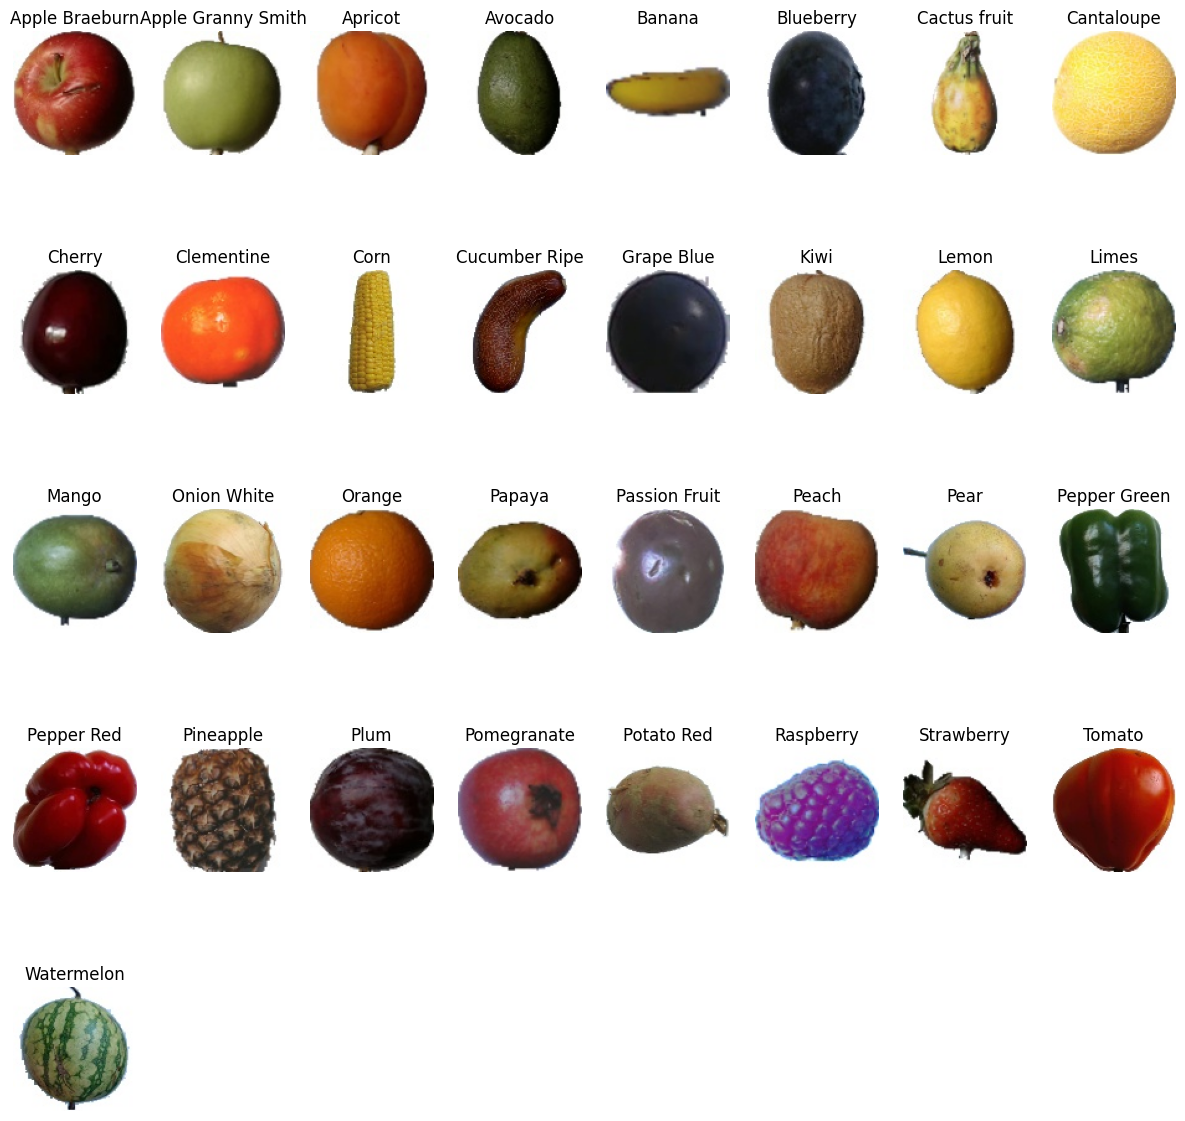

In [8]:
# Trace uma grade de imagens de um conjunto de dados de treinamento
def view_random_image(target_dir, target_class):
  # Configure o diretório de destino (veremos as imagens daqui)
  target_folder = target_dir+target_class
  # Obtenha um caminho de imagem aleatório
  random_image = random.sample(os.listdir(target_folder), 100)
  # Leia a imagem e plote-a usando matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  return img

#----------------------------------------------------------------------
plt.figure(figsize = (15,15))
# Veja uma imagem aleatória do conjunto de dados de treinamento para todas as classes
for i in range(33):
    plt.subplot(5,8,i+1)
    img = view_random_image(target_dir=train_path,
                        target_class=class_names[i])

### Reduzir tamanho dos datasets

#### Treinamento(Validação):

* Preparando Dados de VALIDAÇÃO TREINAMENTO :
Coleta informações sobre o conjunto de dados de treinamento percorrendo a árvore de diretórios usando os.walk() e preenchendo um dicionário chamado train_val_data.

In [9]:
train_val_data = {'path' : [],
       'filename': [],
       'label': []}
for dirpath, dirnames, filenames in os.walk(train_path):
    for f in filenames:
        train_val_data['path'].append(dirpath)
        train_val_data['filename'].append(f)
        train_val_data['label'].append(f.split('_')[0])

Esse código em Python cria um DataFrame do pandas chamado train_val_data_df a partir dos dados contidos na variável train_val_data. Em seguida, ele utiliza o método sample() do DataFrame para amostrar uma fração dos dados, especificamente 88% (frac=0.88). O parâmetro random_state=42 define a semente aleatória para garantir a reprodutibilidade do processo de amostragem.

In [10]:
train_val_data_df = pd.DataFrame(train_val_data)

train_val_data_df = train_val_data_df.sample(frac=0.88, random_state=42)

train_val_data_df.head()

,path,filename,label
11507,../content/fruit-recognition/train/train/Cucum...,Cucumber Ripe_282.jpg,Cucumber Ripe
7895,../content/fruit-recognition/train/train/Peppe...,Pepper Green_173.jpg,Pepper Green
6264,../content/fruit-recognition/train/train/Apple...,Apple Braeburn_263.jpg,Apple Braeburn
5456,../content/fruit-recognition/train/train/Mango,Mango_234.jpg,Mango
9838,../content/fruit-recognition/train/train/Limes,Limes_124.jpg,Limes


#### Teste:

* Preparando Dados de TESTE :
Coleta informações sobre o conjunto de dados de Teste percorrendo a árvore de diretórios usando os.walk() e preenchendo um dicionário chamado test_data.

Prepare os dados de teste, Leia os dados de teste e crie um dataframe:

In [11]:
test_data = {'path' : [],
       'filename': []}
for dirpath, dirnames, filenames in os.walk(test_path):
    for f in filenames:
        test_data['path'].append(dirpath)
        test_data['filename'].append(f)

Este código cria um DataFrame pandas chamado test_data_df a partir dos dados contidos na variável test_data. Em seguida, ele utiliza o método sample() do DataFrame para amostrar uma fração dos dados, especificamente 88% (frac=0.88). O parâmetro random_state=42 define a semente aleatória para garantir a reprodutibilidade do processo de amostragem.

In [12]:
test_data_df = pd.DataFrame(test_data)

test_data_df = test_data_df.sample(frac=0.88, random_state=42)

test_data_df.head()

,path,filename
2124,../content/fruit-recognition/test/test/,0554.jpg
1609,../content/fruit-recognition/test/test/,1712.jpg
3493,../content/fruit-recognition/test/test/,0466.jpg
4856,../content/fruit-recognition/test/test/,5111.jpg
101,../content/fruit-recognition/test/test/,0704.jpg


### Carregando imagens e criando um array de dados

#### Treinamento(Validação)

Este código carrega imagens de um diretório com base nos caminhos especificados em um DataFrame chamado train_val_data_df. Ele itera sobre cada linha desse DataFrame, onde cada linha representa um exemplo de treinamento ou validação.

Para cada linha, o código carrega a imagem do caminho especificado usando a função load_img() e converte-a em um array numpy usando a função img_to_array(). Essas imagens são então armazenadas na lista images. Além disso, as etiquetas correspondentes a cada imagem são armazenadas na lista label.

Após iterar sobre todos os exemplos de treinamento e validação, o código converte as listas images e label em arrays numpy usando np.array(). Em seguida, imprime a forma dos arrays resultantes, o que dá uma ideia do tamanho do conjunto de dados.

In [13]:
images = []
label = []
for _, d in train_val_data_df.iterrows():
    img = load_img(os.path.join(d['path'],d['filename']))
    images.append(img_to_array(img))
    label.append(d['label'])

#---------------------------------------------------------------------
images = np.array(images)
labels = np.array(label)
print(f"Complete data images shape: {images.shape} and label shape: {labels.shape}")

Complete data images shape: (14832, 100, 100, 3) and label shape: (14832,)


Essa saída indica que o conjunto de dados consiste em 14832 imagens, onde cada imagem tem dimensões de 100x100 pixels e possui 3 canais de cor (RGB)

#### Teste

Esse código carrega imagens de um diretório com base nos caminhos especificados em um DataFrame chamado test_data_df. Ele itera sobre cada linha desse DataFrame, onde cada linha representa um exemplo de teste.

Para cada linha, o código carrega a imagem do caminho especificado usando a função load_img() e converte-a em um array numpy usando a função img_to_array(). Essas imagens são então armazenadas na lista test_images.

Após iterar sobre todos os exemplos de teste, o código converte a lista test_images em um array numpy usando np.array(). Em seguida, imprime a forma do array resultante, o que dá uma ideia do tamanho do conjunto de dados de teste.

In [14]:
test_images = []

for _, d in test_data_df.iterrows():
    img = load_img(os.path.join(d['path'],d['filename']))
    test_images.append(img_to_array(img))

test_images = np.array(test_images)
print(f"Test images shape: {test_images.shape} ")

Test images shape: (4964, 100, 100, 3) 


o conjunto de dados de teste contém 4964 imagens. Cada imagem tem dimensões de 100x100 pixels e possui 3 canais de cor (RGB).

### Codificação das classes em valores númericos

In [15]:
# Codificação de etiqueta
class_indices = dict(zip(class_names, range(len(class_names))))
labels_encoded = list(map(class_indices.get, labels))

#Converter para dados categóricos usando tensorflow
#labels para codificação One-hot
label_categorical = tf.keras.utils.to_categorical(labels_encoded, num_classes=len(class_names), dtype='uint8')

In [16]:
print(class_indices)

{'Apple Braeburn': 0, 'Apple Granny Smith': 1, 'Apricot': 2, 'Avocado': 3, 'Banana': 4, 'Blueberry': 5, 'Cactus fruit': 6, 'Cantaloupe': 7, 'Cherry': 8, 'Clementine': 9, 'Corn': 10, 'Cucumber Ripe': 11, 'Grape Blue': 12, 'Kiwi': 13, 'Lemon': 14, 'Limes': 15, 'Mango': 16, 'Onion White': 17, 'Orange': 18, 'Papaya': 19, 'Passion Fruit': 20, 'Peach': 21, 'Pear': 22, 'Pepper Green': 23, 'Pepper Red': 24, 'Pineapple': 25, 'Plum': 26, 'Pomegranate': 27, 'Potato Red': 28, 'Raspberry': 29, 'Strawberry': 30, 'Tomato': 31, 'Watermelon': 32}


In [17]:
print(labels_encoded)

[11, 23, 0, 16, 15, 13, 30, 18, 23, 7, 20, 19, 12, 18, 28, 30, 17, 26, 3, 2, 25, 2, 9, 12, 1, 12, 23, 23, 27, 6, 0, 11, 31, 25, 12, 1, 20, 12, 19, 22, 28, 0, 22, 31, 24, 30, 12, 0, 22, 31, 17, 25, 9, 28, 14, 20, 22, 16, 18, 5, 15, 6, 15, 8, 24, 19, 11, 24, 22, 22, 0, 9, 12, 29, 12, 15, 8, 0, 16, 15, 22, 1, 21, 32, 31, 12, 21, 26, 28, 28, 7, 31, 2, 19, 24, 16, 24, 8, 15, 1, 21, 30, 31, 15, 17, 15, 30, 27, 17, 7, 17, 23, 9, 17, 22, 25, 32, 29, 31, 9, 3, 31, 23, 0, 5, 28, 1, 30, 29, 9, 27, 24, 23, 32, 8, 22, 16, 9, 19, 25, 4, 28, 5, 21, 9, 7, 27, 23, 24, 26, 1, 7, 0, 30, 31, 20, 31, 31, 2, 9, 9, 23, 12, 15, 1, 32, 8, 32, 21, 7, 1, 5, 10, 23, 24, 12, 4, 17, 15, 14, 24, 28, 10, 5, 7, 20, 22, 9, 27, 17, 13, 5, 0, 15, 23, 3, 21, 27, 17, 5, 4, 15, 19, 31, 31, 29, 12, 0, 17, 18, 1, 19, 4, 19, 32, 11, 12, 21, 3, 9, 8, 6, 21, 15, 30, 26, 25, 32, 26, 16, 21, 0, 12, 0, 20, 26, 21, 3, 19, 0, 16, 4, 19, 27, 29, 29, 11, 30, 25, 9, 25, 20, 5, 3, 30, 27, 28, 0, 28, 31, 8, 17, 25, 6, 2, 13, 15, 25, 2, 6,

In [18]:
print(label_categorical)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


### Divisão de treinamento, validação e Teste

train_test_split(images, label_categorical, test_size=0.20, stratify=label_categorical, random_state=40, shuffle=True): Essa função divide os dados em conjuntos de treinamento e validação. Ela recebe como entrada as imagens (images) e as etiquetas categóricas (label_categorical). O parâmetro test_size=0.20 indica que 20% dos dados serão utilizados como conjunto de validação, enquanto os 80% restantes serão utilizados como conjunto de treinamento. O parâmetro stratify=label_categorical garante que a distribuição das classes seja mantida entre os conjuntos de treinamento e validação. O parâmetro random_state=40 define uma semente aleatória para garantir a reprodutibilidade da divisão dos dados. O parâmetro shuffle=True indica que os dados serão embaralhados antes da divisão.

In [19]:
# Divisão de treinamento e validação
train_im, valid_im, train_lab, valid_lab = train_test_split(images, label_categorical, test_size=0.20,
                                                            stratify=label_categorical,
                                                            random_state=40, shuffle = True)
print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

train data shape after the split:  (11865, 100, 100, 3)
new validation data shape:  (2967, 100, 100, 3)
validation labels shape:  (2967, 33)


> * Após a divisão do conjunto de dados, o conjunto de treinamento (train data) possui 11865 imagens. Cada imagem tem dimensões de 100x100 pixels e 3 canais de cor (RGB).
* O novo conjunto de validação (new validation data) possui 2967 imagens. Cada imagem também tem dimensões de 100x100 pixels e 3 canais de cor (RGB).
* As etiquetas correspondentes às imagens de validação (validation labels) têm 2967 elementos, correspondendo às 2967 imagens de validação. Cada etiqueta é representada por um vetor categórico de tamanho 33, indicando a categoria da imagem. Isso sugere que há 33 classes diferentes nas quais as imagens são classificadas.

In [20]:
print ('train im and label types: ', type(train_im), type(train_lab))

training_data = tf.data.Dataset.from_tensor_slices((train_im, train_lab))
validation_data = tf.data.Dataset.from_tensor_slices((valid_im, valid_lab))
test_data = tf.data.Dataset.from_tensor_slices(test_images)

print ('check types; ', type(training_data), type(validation_data), type(test_data))

train im and label types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
check types;  <class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'> <class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'> <class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'>


> * training_data = tf.data.Dataset.from_tensor_slices((train_im, train_lab)): Cria um objeto Dataset do TensorFlow a partir das imagens de treinamento (train_im) e suas etiquetas correspondentes (train_lab). Este método from_tensor_slices é usado para criar um conjunto de dados a partir de tensores (arrays numpy) e é frequentemente usado para processar dados em lotes durante o treinamento de modelos de aprendizado profundo.
* validation_data = tf.data.Dataset.from_tensor_slices((valid_im, valid_lab)): Similar ao comando anterior, cria um objeto Dataset do TensorFlow para os dados de validação, com as imagens de validação (valid_im) e suas etiquetas (valid_lab).
* test_data = tf.data.Dataset.from_tensor_slices(test_images): Cria um objeto Dataset do TensorFlow para os dados de teste, contendo as imagens de teste (test_images). Assim como nos casos anteriores, isso permite que os dados sejam processados em lotes durante a avaliação do modelo.

## Explorando TensorFlow

In [ ]:
# verifique usando element_spec
print (training_data.element_spec)
print (validation_data.element_spec)

# como esperado, tensores de imagem e formato original do rótulo
# crie um iterador e transforme-o em um array numpy
train_iter = iter(training_data)
print(next(train_iter)[0].numpy(), '\n', next(train_iter)[1].numpy(), np.argmax(next(train_iter)[1].numpy()))

In [22]:
train_iter_im, train_iter_label = next(iter(training_data))
print (train_iter_im.numpy().shape, train_iter_label.numpy().shape)

(100, 100, 3) (33,)


> Este código realiza as seguintes operações:
> * train_iter_im, train_iter_label = next(iter(training_data)): Utiliza a função next() para obter o próximo elemento do iterador training_data. Como training_data é um objeto do tipo Dataset do TensorFlow, ele fornece pares de tensores, onde train_iter_im representa a imagem e train_iter_label representa a etiqueta correspondente.
* train_iter_im.numpy().shape: Converte o tensor train_iter_im em um array numpy e retorna sua forma, que representa as dimensões da imagem. Isso fornece a forma da imagem do primeiro elemento do conjunto de dados de treinamento.
* train_iter_label.numpy().shape: Converte o tensor train_iter_label em um array numpy e retorna sua forma, que representa as dimensões da etiqueta. Isso fornece a forma da etiqueta do primeiro elemento do conjunto de dados de treinamento.

In [23]:
train_iter_im1, train_iter_label1 = next(training_data.as_numpy_iterator())
print (train_iter_im1.shape, train_iter_label1.shape)

(100, 100, 3) (33,)


>Este código realiza as seguintes operações:
* train_iter_im1, train_iter_label1 = next(training_data.as_numpy_iterator()): Usa o método as_numpy_iterator() para criar um iterador que converte os elementos do conjunto de dados em arrays numpy. Em seguida, utiliza a função next() para obter o próximo elemento deste iterador. Como resultado, train_iter_im1 representa a imagem e train_iter_label1 representa a etiqueta correspondente do primeiro elemento do conjunto de dados de treinamento.
* train_iter_im1.shape: Obtém a forma do array numpy train_iter_im1, que representa as dimensões da imagem.
* train_iter_label1.shape: Obtém a forma do array numpy train_iter_label1, que representa as dimensões da etiqueta.






### Visualizando a lista de check up

In [ ]:
check_list = list(training_data.as_numpy_iterator())
print (len(check_list), check_list[1])

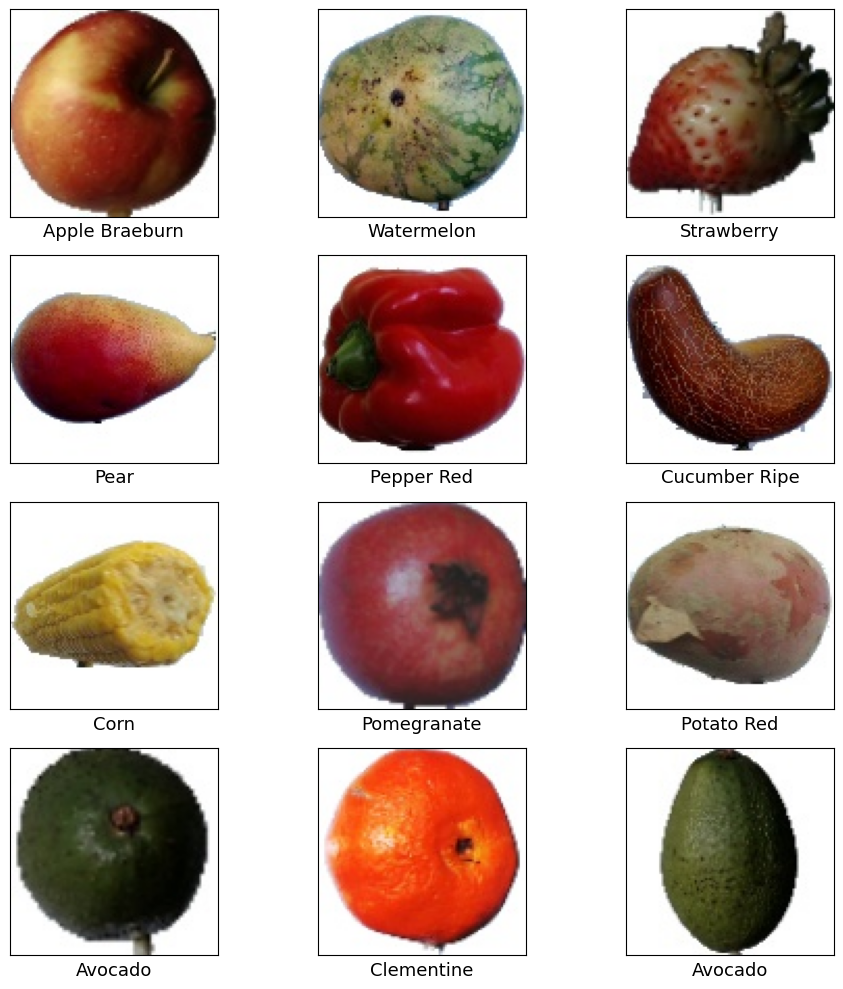

In [25]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(check_list[i][0]/255.)
    plt.xlabel(class_names[np.argmax(check_list[i][1])], fontsize=13)
plt.tight_layout()
plt.show()


Esse trecho de código cria duas sequências de pré-processamento de dados usando a API de pré-processamento de dados do TensorFlow (tf.keras.preprocessing). Essas sequências serão usadas posteriormente para construir um pipeline de dados eficiente usando tf.data.

* rescale_data: Esta sequência é uma etapa de pré-processamento que aplica uma transformação de rescale aos dados. A camada Rescaling(1/255.) normaliza os valores dos pixels das imagens, dividindo cada valor por 255. Isso garante que os valores dos pixels estejam no intervalo [0,1], o que é comum em tarefas de processamento de imagens. Essa etapa é importante para garantir que os modelos de aprendizado profundo funcionem de forma mais eficiente.
* data_augmentation: Esta sequência é uma etapa de pré-processamento que aplica técnicas de aumento de dados (data augmentation) às imagens. No código fornecido, duas técnicas são aplicadas:
RandomFlip(mode="horizontal"): Esta camada aplica uma operação de flip horizontal aleatório às imagens. Isso significa que algumas imagens serão espelhadas horizontalmente. Isso ajuda a aumentar a diversidade do conjunto de dados, tornando o modelo mais robusto a variações nas imagens de entrada.

## Pipeline de dados

In [26]:
# Pipeline de dados usando tf.data e pré-busca
rescale_data = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1/255.)
])
data_augmenation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode = "horizontal"),
    #camadas.experimental.preprocessing.RandomRotation (0.1)
])

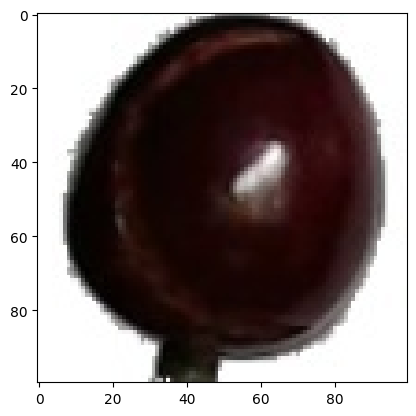

In [27]:
random_image_index = random.randint(0,len(train_im))
img = rescale_data(train_im[random_image_index])
img = data_augmenation(img)
plt.imshow(img)

In [28]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment = False, test = False):
    if test:
        ds = ds.map(lambda x: (rescale_data(x)), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (rescale_data(x), y), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # agrupar os dados
    ds = ds.batch(BATCH_SIZE)

    # Use o aumento de dados apenas no conjunto de treinamento.
    if augment:
        ds = ds.map(lambda x, y: (data_augmenation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

    # Use a pré-busca em buffer em todos os conjuntos de dados.
    return ds.prefetch(buffer_size=AUTOTUNE)

> Este código define uma função chamada prepare que é usada para preparar um conjunto de dados para treinamento, validação ou teste em um pipeline de dados usando tf.data.Dataset.

* BATCH_SIZE = 128: Define o tamanho do lote (batch size) a ser usado no pipeline de dados. Isso determina quantos exemplos de treinamento serão processados de uma vez durante cada passagem de treinamento.
* AUTOTUNE = tf.data.AUTOTUNE: Define o valor AUTOTUNE, que é usado para otimizar o desempenho do pipeline de dados, permitindo que o TensorFlow ajuste dinamicamente a quantidade de recursos de E/S usados.
* A função prepare aceita quatro argumentos:
1. ds: O conjunto de dados a ser preparado.
2. shuffle: Um booleano que indica se os dados devem ser embaralhados.
3. augment: Um booleano que indica se o aumento de dados (data augmentation) deve ser aplicado.
4. test: Um booleano que indica se os dados são do conjunto de teste.
* A função começa aplicando uma transformação de rescale aos dados. Se o conjunto de dados for para teste (test=True), apenas a transformação de rescale é aplicada. Caso contrário, tanto a transformação de rescale quanto a etiqueta correspondente são aplicadas ao conjunto de dados.
* Se shuffle=True, os dados são embaralhados aleatoriamente.
* Em seguida, os dados são agrupados em lotes de tamanho definido por BATCH_SIZE.
* Se augment=True, o aumento de dados é aplicado apenas aos dados de treinamento. Isso inclui a aplicação das técnicas de aumento de dados definidas na sequência data_augmentation.
* Por fim, prefetch é usado para pré-buscar os dados. Isso permite que o pipeline de dados carregue os dados para a próxima etapa de processamento enquanto o modelo está sendo treinado ou avaliado, melhorando a eficiência e o desempenho. O tamanho do buffer é definido por AUTOTUNE, permitindo ao TensorFlow ajustar dinamicamente o tamanho do buffer de acordo com os recursos disponíveis.






In [29]:
train_ds = prepare(training_data, shuffle = True, augment = True)
val_ds = prepare(validation_data)
test_ds = prepare(test_data, test=True)

 esse trecho de código prepara os conjuntos de dados de treinamento, validação e teste para serem usados em um modelo de aprendizado de máquina, aplicando diferentes transformações e preparações específicas para cada conjunto de dados. Os parametros aplicados garantem que os dados seram embaralhados antes de cada época de treinamento (para garantir aleatoriedade) e que o aumento de dados será aplicado durante o treinamento (o que implica em gerar novas imagens a partir das existentes, aplicando pequenas transformações como rotações, reflexões, zoom, etc., para expandir o conjunto de dados de treinamento e melhorar a generalização do modelo).

## Modelo CNN

In [30]:
# Modelo CNN
#O modelo consiste em uma camada convolucional, uma camada de pooling máximo, uma camada achatada e uma camada densa (totalmente conectada) com uma função de ativação softmax
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=5,
                          kernel_size = 3,
                          activation = "relu",
                          input_shape = (100,100,3)),
    tf.keras.layers.MaxPool2D(pool_size =2,
                             padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

model_1.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

In [31]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 5)         140       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 5)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 12005)             0         
                                                                 
 dense (Dense)               (None, 33)                396198    
                                                                 
Total params: 396338 (1.51 MB)
Trainable params: 396338 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* Model: "sequential_5": Indica que o modelo é uma sequência de camadas e é o quinto modelo criado com a classe Sequential.
* Layer (type): Esta coluna lista o tipo de cada camada do modelo.
* Output Shape: Indica a forma da saída de cada camada. Por exemplo, (None, 98, 98, 5) significa que a saída da camada convolucional é um tensor tridimensional com uma forma de (batch_size, 98, 98, 5), onde batch_size é o tamanho do lote.
* Param #: Representa o número de parâmetros treináveis em cada camada. Por exemplo, a camada convolucional tem 140 parâmetros (pesos e vieses) no total. A camada densa tem 396198 parâmetros. O número total de parâmetros no modelo é dado por Total params, que é a soma dos parâmetros em todas as camadas.
* Total params: Indica o número total de parâmetros no modelo, incluindo os parâmetros treináveis e não treináveis.
* Trainable params: Indica o número de parâmetros que serão atualizados durante o treinamento do modelo.
* Non-trainable params: Indica o número de parâmetros que não serão atualizados durante o treinamento do modelo. Isso inclui os parâmetros de camadas como a camada de achatamento (Flatten) que não têm parâmetros treináveis.

In [ ]:
#Ajustando o modelo
#Ajuste o modelo aos dados de treinamento
history_1 = model_1.fit(train_ds,
                       epochs =25,
                       validation_data= val_ds)

<Axes: >

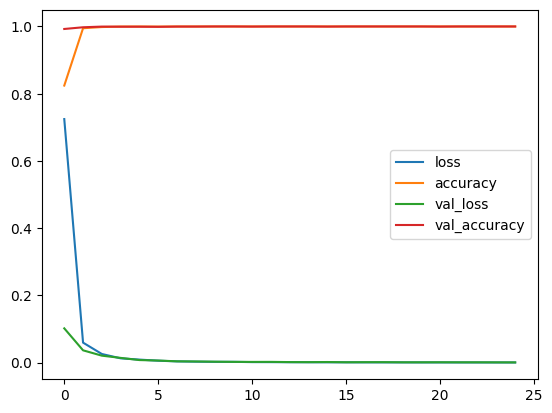

In [33]:
#Plotting Gráfico para perda e precisão
#gráfico de perda e precisão
pd.DataFrame(history_1.history).plot()

In [34]:
# salvando o modelo
model_1.save('model.keras')

In [35]:
loaded_model = tf.keras.models.load_model('model.keras')

In [36]:
def preprocess_images(path):
    img = image.load_img(path, target_size=(224, 224))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_array / 255.0

    return img_preprocessed